In [210]:
from cProfile import label
from netrc import netrc

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

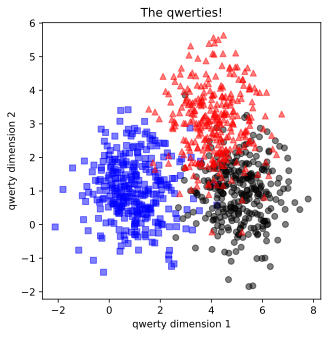

In [211]:
# create data

nPerClus = 300
blur = 1
A = [1,1]
B = [5,1]
C = [4,3]

a = [A[0]+np.random.randn(nPerClus)*blur , A[1]+np.random.randn(nPerClus)*blur]
b = [B[0]+np.random.randn(nPerClus)*blur , B[1]+np.random.randn(nPerClus)*blur]
c = [C[0]+np.random.randn(nPerClus)*blur , C[1]+np.random.randn(nPerClus)*blur]

# true labels
labels_np = np.hstack((
    np.zeros((nPerClus)),
    np.ones((nPerClus)),
    1+np.ones((nPerClus))
))

# concatanate into matrix 
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note : "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=0.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=0.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=0.5)
plt.title("The qwerties!")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [212]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)

# convert them to PyTorch DataSets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batch_size = 16
train_laoder = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
test_laoder = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [213]:
# how many batches are there?

print(f"There are {len(train_data)} batches, each with {batch_size} samples.")

There are 720 batches, each with 16 samples.


### Create and validate the model

In [214]:
# create a class for the model
def createTheQwertyNet():
    
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            ### input layer
            self.input = nn.Linear(2,8)
            
            ### hidden layer
            self.fc1 = nn.Linear(8,8)
            self.fc2 = nn.Linear(8,8)
            
            ### output layer
            self.output = nn.Linear(8,3)
            
        def forward(self,x):
            x = self.input(x)
            x = F.relu(x)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.output(x)
            return x
    
    # create the model instance
    net = qwertyNet()

    # loss function
    lossFn = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    return net,lossFn,optimizer

In [215]:
# test the model with fake input

net,lossFn,optimizer = createTheQwertyNet()
print(net)

# input is ten samples
input = torch.rand(10,2)
net(input)

qwertyNet(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[ 0.3143, -0.0072,  0.4169],
        [ 0.3164, -0.0078,  0.4139],
        [ 0.3272, -0.0187,  0.4008],
        [ 0.3158, -0.0103,  0.4176],
        [ 0.3113, -0.0063,  0.4162],
        [ 0.3168, -0.0080,  0.4110],
        [ 0.3155, -0.0073,  0.4151],
        [ 0.3161, -0.0075,  0.4143],
        [ 0.3132, -0.0109,  0.4206],
        [ 0.3141, -0.0104,  0.4203]], grad_fn=<AddmmBackward0>)

### A function that train modeL

In [216]:
def funcTrainModel():
    
    # number of epoches
    num_epochs = 100
    
    # create a new model
    net,lossFn,optimizer = createTheQwertyNet()
    
    # init losses
    losses = torch.zeros(num_epochs)
    trainAcc = []
    testAcc = []
    
    # loop through epochs
    for epochI in range(num_epochs):
        
        # switch on training mode
        net.train()
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X,y in train_laoder:
            
            yHat = net(X)
            loss = lossFn(yHat,y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            # compute acc
            matches = torch.argmax(yHat,dim=1) == y # bool (false/true)
            matchNumeric = matches.float() # convert to numbers (0/1)
            accPct = 100*torch.mean(matchNumeric) # avg and x100
            batchAcc.append(accPct)
        
        trainAcc.append(np.mean(batchAcc))
        
        # avg losses across batches
        losses[epochI] = np.mean(batchLoss)
        
        # test acc
        net.eval()
        X,y = next(iter(test_laoder))
        with torch.no_grad():
            yHat = net(X)
            
        testAcc.append(100*torch.mean((torch.argmax(yHat,dim=1) == y).float()))
    # end epochs    
    return trainAcc,testAcc,losses

In [217]:
trainAcc,testAcc,losses = funcTrainModel()

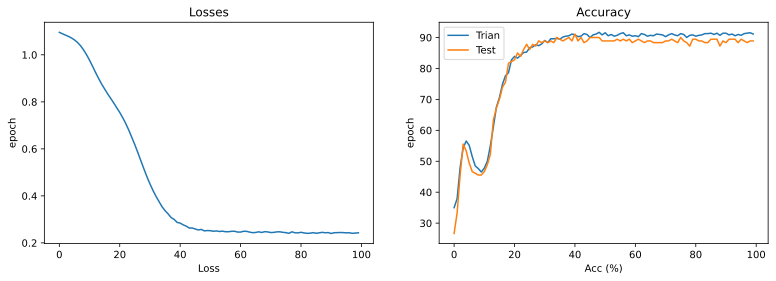

In [218]:
fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_xlabel('Loss')
ax[0].set_ylabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,label="Trian")
ax[1].plot(testAcc,label="Test")
ax[1].set_xlabel('Acc (%)')
ax[1].set_ylabel('epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

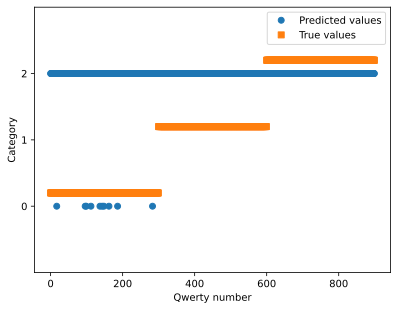

In [219]:
# run the data through the model to get the categorical predictions
yHat = net(data)
predications = torch.argmax(yHat,dim=1)

# plot those against real data
plt.plot(predications,'o',label="Predicted values")
plt.plot(labels+.2,'s',label="True values")
plt.xlabel('Qwerty number')
plt.ylabel("Category")
plt.yticks([0,1,2])
plt.ylim([-1,3])
plt.legend()
plt.show()

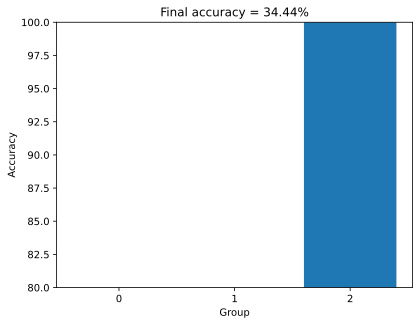

In [220]:
# recode each prediction by acc
acc = (predications == labels).float()

totalAcc = torch.mean(100*acc).item()

accByGroup = np.zeros(3)
for i in range(3):
    accByGroup[i] = 100*torch.mean(acc[labels == i])
    
plt.bar(range(3),accByGroup)
plt.ylim([80,100])
plt.xticks([0,1,2])
plt.xlabel("Group")
plt.ylabel("Accuracy")
plt.title(f"Final accuracy = {totalAcc:.2f}%")
plt.show()

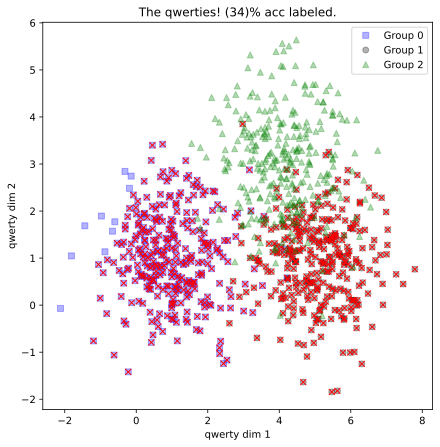

In [221]:
# data markers
colorShapes = ['bs','ko','g^']

fig = plt.figure(figsize=(7,7))

# plot correct and incorrect labeled data
for i in range(3):
    # plot all data points for this label
    plt.plot(data[labels==i,0],data[labels==i,1],colorShapes[i], alpha=0.3,label=f'Group {i}')
    
    idxErr = (acc == 0) & (labels == i)
    plt.plot(data[idxErr,0],data[idxErr,1],'rx')
    
plt.title(f"The qwerties! ({totalAcc:.0f})% acc labeled.")
plt.xlabel("qwerty dim 1")
plt.ylabel("qwerty dim 2")
plt.legend()
plt.show()
